In [1]:
! pip install -U nilearn
! pip install segmentation-models-3D
! pip install classification-models-3D
! pip install visualkeras
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt
import os
#General Libraries

import shutil
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

#Model libraries
import tensorflow as tf
from tensorflow import keras
import visualkeras
# from keras.utils.vis_utils import plot_model
from tensorflow.keras.utils import plot_model
import segmentation_models_3D as sm
from keras import callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

TRAIN_DATASET_PATH='/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 64.3 MB/s eta 0:00:0000:010:01
  Attempting uninstall: nilearn
    Found existing installation: nilearn 0.10.1
    Uninstalling nilearn-0.10.1:
      Successfully uninstalled nilearn-0.10.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 68.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.6/69.6 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 84.8 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 40.9 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of tensorflow to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.9/489.9 MB 2.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Segmentation Models: using `tf.keras` framework.


In [2]:
# import os
# import numpy as np
# from skimage.transform import resize
# from skimage import exposure

# def resize_3d_image(image, new_shape):
#     resized_image = np.zeros(new_shape)
#     for i in range(image.shape[-1]):
#         resized_image[..., i] = resize(image[..., i], new_shape[:-1], mode='constant', anti_aliasing=True)
#     return resized_image

# def histogram_equalization_3d(image):
#     equalized_image = np.zeros_like(image)
#     for i in range(image.shape[-1]):
#         equalized_image[..., i] = exposure.equalize_hist(image[..., i], nbins=128)
#     return equalized_image

# def process_images_in_folder(folder_path, output_folder_path):
#     # Ensure output folder exists
#     os.makedirs(output_folder_path, exist_ok=True)

#     # List all files in the input folder
#     files = os.listdir(folder_path)

#     for file in files:
#         # Assuming the images are in a specific format (e.g., '.npy'). Modify accordingly.
#         if file.endswith('.npy'):
#             # Load the image
#             original_image = np.load(os.path.join(folder_path, file))

#             # Resize the image
#             new_shape = (25, 25, 25, 3)
#             resized_image = resize_3d_image(original_image, new_shape)

#             # Histogram equalization
#             equalized_image = histogram_equalization_3d(resized_image)

#             # Save the processed image to the output folder
#             output_file_path = os.path.join(output_folder_path, file)
#             np.save(output_file_path, equalized_image)

# if __name__ == "__main__":
#     # Specify the input and output folders
#     input_folder_path = "/path/to/input_folder"
#     output_folder_path = "/path/to/output_folder"

#     # Process images in the input folder and save to the output folder
#     process_images_in_folder(input_folder_path, output_folder_path)


In [3]:
#get the list of all folders. Exclude 'BraTS20_Training_355'. As its segmenation image has some weired name.
Data_dir = [f.path for f in os.scandir('/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData') if f.is_dir()]
def Name(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x
n=Name(Data_dir)
N=[t for t in n if t!='BraTS20_Training_355']#This file has weird seg name

In [4]:
class Image_explorer:
    def __init__(self):
        np.random.seed(4)
        i=np.random.randint(0,len(N)-1)
        path=os.path.join(TRAIN_DATASET_PATH,N[i])
        p=os.listdir(path)
        t1 = [i for i, s in enumerate(p) if 't1.nii' in s]
        t2 = [i for i, s in enumerate(p) if 't2.nii' in s]
        t1ce = [i for i, s in enumerate(p) if 't1ce.nii' in s]
        seg = [i for i, s in enumerate(p) if 'seg.nii' in s]
        flair = [i for i, s in enumerate(p) if 'flair.nii' in s]
        self.test_image_flair=nib.load(os.path.join(path,p[flair[0]])).get_fdata()
        self.test_image_t1=nib.load(os.path.join(path,p[t1[0]])).get_fdata()
        self.test_image_t1ce=nib.load(os.path.join(path,p[t1ce[0]])).get_fdata()
        self.test_image_t2=nib.load(os.path.join(path,p[t2[0]])).get_fdata()
        self.test_seg=nib.load(os.path.join(path,p[seg[0]])).get_fdata()

    def Axial_View(self,layer):
        fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 5))
        ax1.imshow(self.test_image_flair[:,:,layer], cmap = 'gray')
        ax1.set_title('Flair')
        ax2.imshow(self.test_image_t1[:,:,layer], cmap = 'gray')
        ax2.set_title('T1')
        ax3.imshow(self.test_image_t1ce[:,:,layer], cmap = 'gray')
        ax3.set_title('T1ce')
        ax4.imshow(self.test_image_t2[:,:,layer], cmap = 'gray')
        ax4.set_title('T2')
        ax5.imshow(self.test_seg[:,:,layer])
        ax5.set_title('Segmented')
        fig.suptitle('Axial View',fontsize=30)
        fig.tight_layout()
        plt.show()

    def Sagittal_View(self,layer):
        fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 5))
        ax1.imshow(np.rot90(self.test_image_flair[layer,:,:]), cmap = 'gray')
        ax1.set_title('Flair')
        ax2.imshow(np.rot90(self.test_image_t1[layer,:,:]), cmap = 'gray')
        ax2.set_title('T1')
        ax3.imshow(np.rot90(self.test_image_t1ce[layer,:,:]), cmap = 'gray')
        ax3.set_title('T1ce')
        ax4.imshow(np.rot90(self.test_image_t2[layer,:,:]), cmap = 'gray')
        ax4.set_title('T2')
        ax5.imshow(np.rot90(self.test_seg[layer,:,:]))
        ax5.set_title('Segmented')
        fig.suptitle('Sagittal View',fontsize=30)
        fig.tight_layout()
        plt.show()

    def Coronal_View(self,layer):
        fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 5))
        ax1.imshow(np.rot90(self.test_image_flair[:,layer,:]), cmap = 'gray')
        ax1.set_title('Flair')
        ax2.imshow(np.rot90(self.test_image_t1[:,layer,:]), cmap = 'gray')
        ax2.set_title('T1')
        ax3.imshow(np.rot90(self.test_image_t1ce[:,layer,:]), cmap = 'gray')
        ax3.set_title('T1ce')
        ax4.imshow(np.rot90(self.test_image_t2[:,layer,:]), cmap = 'gray')
        ax4.set_title('T2')
        ax5.imshow(np.rot90(self.test_seg[:,layer,:]))
        ax5.set_title('Segmented')
        fig.suptitle('Coronal View',fontsize=30)
        fig.tight_layout()
        plt.show()

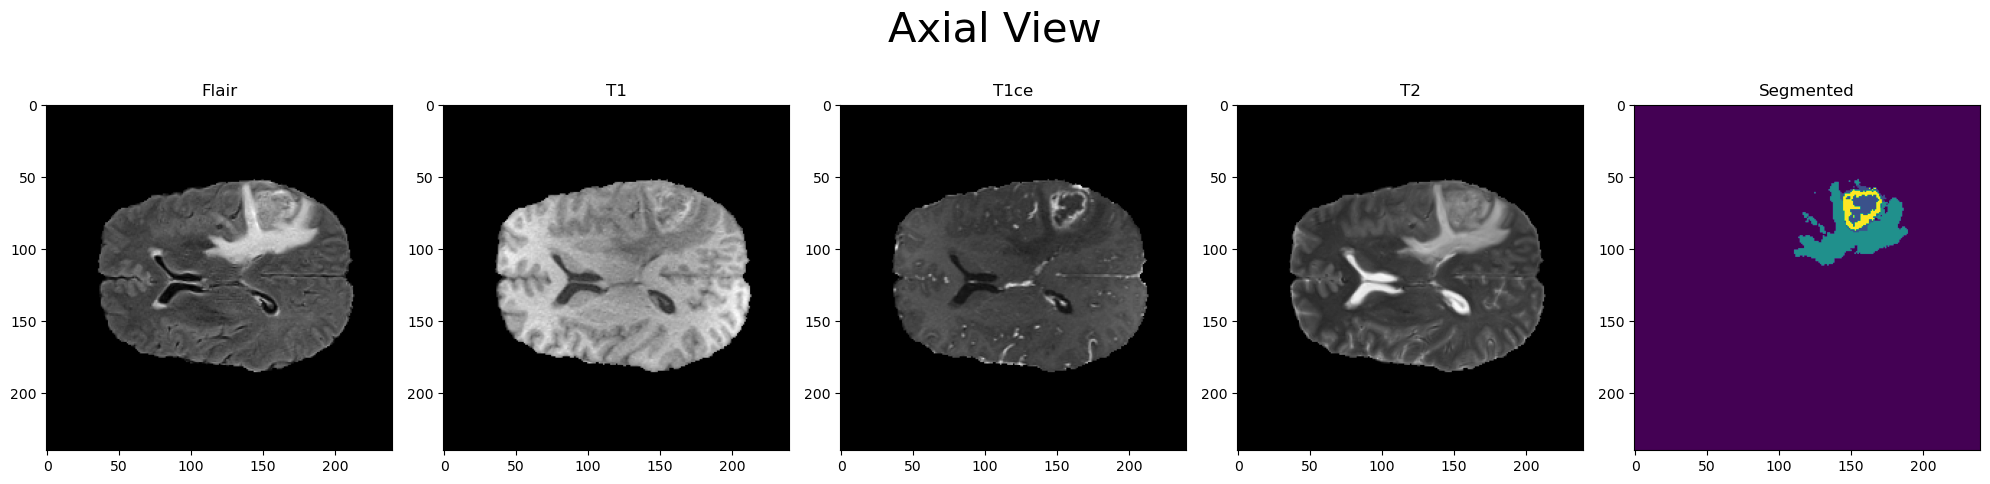

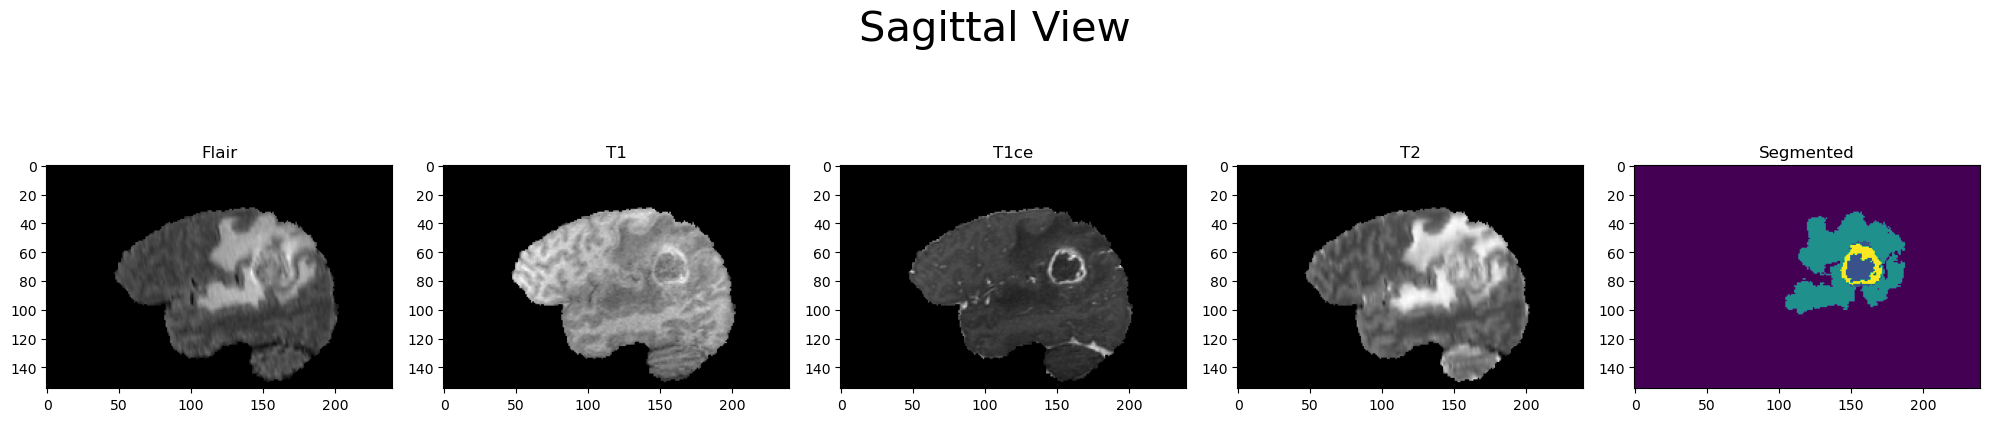

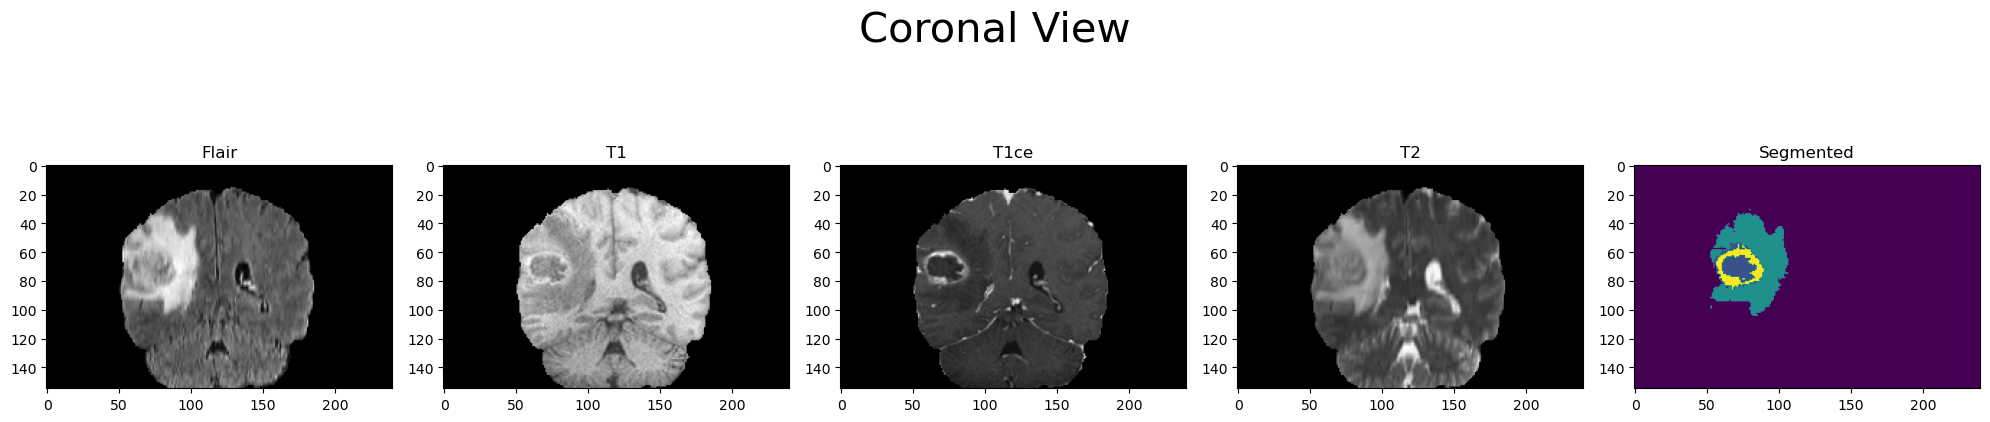

In [5]:
test_image_flair=nib.load('/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/BraTS20_Training_355_flair.nii').get_fdata()
Image=Image_explorer
Image().Axial_View(layer=75);
Image().Sagittal_View(layer=75)
Image().Coronal_View(layer=150)

In [6]:
import os

# Define the main folder path
main_folder = '/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'

# Get a list of all items (files and folders) within the main folder
all_items = os.listdir(main_folder)

# Filter out only the folders
subfolders = [item for item in all_items if os.path.isdir(os.path.join(main_folder, item))]

# Print the list of subfolders
print("Subfolders:")
for subfolder in subfolders[:5]:
    # List .nii files in the folder
    nii_files = [file for file in os.listdir('/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'+subfolder) if file.endswith('.nii')]

    # Iterate over the .nii files
    for filename in nii_files:
        file_path = os.path.join('/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'+subfolder, filename)
        img = nib.load(file_path)
        data = img.get_fdata()

        # Print the shape of the loaded data
        print(f"Shape of {filename}: {data.shape}")


Subfolders:
Shape of BraTS20_Training_083_flair.nii: (240, 240, 155)
Shape of BraTS20_Training_083_t1.nii: (240, 240, 155)
Shape of BraTS20_Training_083_seg.nii: (240, 240, 155)
Shape of BraTS20_Training_083_t2.nii: (240, 240, 155)
Shape of BraTS20_Training_083_t1ce.nii: (240, 240, 155)
Shape of BraTS20_Training_337_t1ce.nii: (240, 240, 155)
Shape of BraTS20_Training_337_t1.nii: (240, 240, 155)
Shape of BraTS20_Training_337_seg.nii: (240, 240, 155)
Shape of BraTS20_Training_337_t2.nii: (240, 240, 155)
Shape of BraTS20_Training_337_flair.nii: (240, 240, 155)
Shape of BraTS20_Training_161_t1ce.nii: (240, 240, 155)
Shape of BraTS20_Training_161_t2.nii: (240, 240, 155)
Shape of BraTS20_Training_161_t1.nii: (240, 240, 155)
Shape of BraTS20_Training_161_seg.nii: (240, 240, 155)
Shape of BraTS20_Training_161_flair.nii: (240, 240, 155)
Shape of BraTS20_Training_198_t1.nii: (240, 240, 155)
Shape of BraTS20_Training_198_flair.nii: (240, 240, 155)
Shape of BraTS20_Training_198_t2.nii: (240, 240, 

In [7]:
# import os
# import nibabel as nib
# import numpy as np

# # Define the main folder path
# main_folder = '/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'

# # Define the output folder path
# output_folder = '/kaggle/working/processed_images/training'

# # Create the output folder if it doesn't exist
# os.makedirs(output_folder, exist_ok=True)

# # Define a function for histogram equalization
# def histogram_equalization_3d(data):
#     # Your implementation of histogram equalization for 3D data
#     # This function is assumed to perform histogram equalization on each slice of the 3D volume
#     return data  # Placeholder, replace with actual implementation

# # Get a list of all items (files and folders) within the main folder
# all_items = os.listdir(main_folder)

# # Filter out only the folders
# subfolders = [item for item in all_items if os.path.isdir(os.path.join(main_folder, item))]

# # Print the list of subfolders
# print("Subfolders:")
# for subfolder in subfolders[:5]:
#     # List .nii files in the folder
#     nii_files = [file for file in os.listdir(os.path.join(main_folder, subfolder)) if file.endswith('.nii')]

#     # Iterate over the .nii files
#     for filename in nii_files:
#         file_path = os.path.join(main_folder, subfolder, filename)
#         img = nib.load(file_path)
#         data = img.get_fdata()
        
#         # Apply histogram equalization
#         image = histogram_equalization_3d(data)

#         # Print the shape of the loaded data
#         print(f"Shape of {filename}: {image.shape}")

#         # Create the directory for the current subfolder if it doesn't exist
#         output_subfolder = os.path.join(output_folder, subfolder)
#         os.makedirs(output_subfolder, exist_ok=True)

#         # Save the processed image to the output folder
#         output_file_path = os.path.join(output_subfolder, filename)  # Modify the filename if needed
#         nib.save(nib.Nifti1Image(image, img.affine), output_file_path)


In [8]:
# import shutil
# import os

# # Define the directory path to be deleted
# directory_to_delete = '/kaggle/working/processed_images'

# # Check if the directory exists
# if os.path.exists(directory_to_delete):
#     # Delete the directory and its contents
#     try:
#         shutil.rmtree(directory_to_delete)
#         print(f"Directory '{directory_to_delete}' has been successfully deleted.")
#     except OSError as e:
#         print(f"Error: {directory_to_delete} : {e.strerror}")
# else:
#     print(f"Directory '{directory_to_delete}' does not exist.")


In [9]:
import numpy as np
from skimage.transform import resize

def resize_3d_image(image, new_shape):
    resized_image = np.zeros(new_shape)
    for i in range(image.shape[-1]):
        resized_image[..., i] = resize(image[..., i], new_shape[:-1], mode='constant', anti_aliasing=True)
    return resized_image

# Example usage
original_image = np.random.rand(50, 50, 50, 3)  # Example 3D image with shape (50, 50, 50, 3)
new_shape = (25, 25, 25, 3)  # New shape for the resized image

resized_image = resize_3d_image(original_image, new_shape)


In [10]:
import numpy as np
from skimage import exposure

def histogram_equalization_3d(image):
    equalized_image = np.zeros_like(image)

    for i in range(image.shape[-1]):
        equalized_image[..., i] = exposure.equalize_hist(image[..., i], nbins=128)

    return equalized_image

# Example usage
original_image = np.random.rand(128, 128, 128, 3)  # Example 3D image with shape (128, 128, 128, 3)
equalized_image = histogram_equalization_3d(original_image)


In [11]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, list_IDs, batch_size=1, dim=(128,128,128),shuffle=False,channels=3,num_class=4):
        'Initialization'
        self.dim = dim
        self.n_channels=channels
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.num_class=num_class
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Generate data
        X=np.zeros((self.batch_size,*(self.dim),self.n_channels))
        Y=np.zeros((self.batch_size,*(self.dim),self.num_class))
        for i, ID in enumerate(list_IDs_temp):
            case_path = os.path.join(TRAIN_DATASET_PATH, ID)
            data_path = os.path.join(case_path, f'{ID}_t1.nii')
            t1 = nib.load(data_path).get_fdata()
            st1=MinMaxScaler()
            t1=st1.fit_transform(t1.reshape(-1,t1.shape[-1])).reshape(t1.shape)
            data_path = os.path.join(case_path, f'{ID}_flair.nii')
            flair = nib.load(data_path).get_fdata()
            stflair=MinMaxScaler()
            flair=stflair.fit_transform(flair.reshape(-1,flair.shape[-1])).reshape(flair.shape)
            data_path = os.path.join(case_path, f'{ID}_t1ce.nii')
            t1ce = nib.load(data_path).get_fdata()
            st1ce=MinMaxScaler()
            t1ce=st1ce.fit_transform(t1ce.reshape(-1,t1ce.shape[-1])).reshape(t1ce.shape)
            data_path = os.path.join(case_path, f'{ID}_seg.nii')
            seg = nib.load(data_path)
            x=np.stack([t1,flair,t1ce],axis=3)
            seg=np.array(seg.get_fdata())
            seg[seg==4]=3
            seg=keras.utils.to_categorical(seg,self.num_class)
#             X[i] = resize_3d_image(x, (128,128,128,3))
#             X[i] = histogram_equalization_3d(X[i])
#             Y[i] = resize_3d_image(seg, (128,128,128,4))
            X[i]=x[56:184,56:184,13:141]#this slicing is important as GPU will run out of memory if we take the complete image
            Y[i]=seg[56:184,56:184,13:141]

        return X, Y

In [12]:
# import tensorflow as tf
# from tensorflow.keras.utils import Sequence
# from sklearn.preprocessing import MinMaxScaler
# import numpy as np
# import nibabel as nib
# import os

# class DataGenerator(Sequence):
#     def __init__(self, list_IDs, batch_size=1, dim=(128, 128, 128), shuffle=False, channels=3, num_class=4):
#         'Initialization'
#         self.dim = dim
#         self.n_channels = channels
#         self.batch_size = batch_size
#         self.list_IDs = list_IDs
#         self.shuffle = shuffle
#         self.num_class = num_class
#         self.on_epoch_end()

#     def __len__(self):
#         'Denotes the number of batches per epoch'
#         return int(np.floor(len(self.list_IDs) / self.batch_size))

#     def __getitem__(self, index):
#         'Generate one batch of data'
#         # Generate indexes of the batch
#         indexes = self.indexes[index * self.batch_size: (index + 1) * self.batch_size]
#         # Find list of IDs
#         list_IDs_temp = [self.list_IDs[k] for k in indexes]
#         # Generate data
#         X, y = self.__data_generation(list_IDs_temp)
#         return X, y

#     def on_epoch_end(self):
#         self.indexes = np.arange(len(self.list_IDs))
#         if self.shuffle == True:
#             np.random.shuffle(self.indexes)

#     def __data_generation(self, list_IDs_temp):
#         'Generates data containing batch_size samples'  # X : (n_samples, *dim, n_channels)
#         # Generate data
#         X = np.zeros((self.batch_size, *self.dim, self.n_channels))
#         Y = np.zeros((self.batch_size, *self.dim, self.num_class))

#         for i, ID in enumerate(list_IDs_temp):
#             case_path = os.path.join(TRAIN_DATASET_PATH, ID)

#             # Load the image and get its original size
#             data_path_t1 = os.path.join(case_path, f'{ID}_t1.nii')
#             t1 = nib.load(data_path_t1).get_fdata()
#             original_size = t1.shape

#             # Normalize and stack channels
#             st1 = MinMaxScaler()
#             t1 = st1.fit_transform(t1.reshape(-1, t1.shape[-1])).reshape(t1.shape)

#             data_path_flair = os.path.join(case_path, f'{ID}_flair.nii')
#             flair = nib.load(data_path_flair).get_fdata()
#             stflair = MinMaxScaler()
#             flair = stflair.fit_transform(flair.reshape(-1, flair.shape[-1])).reshape(flair.shape)

#             data_path_t1ce = os.path.join(case_path, f'{ID}_t1ce.nii')
#             t1ce = nib.load(data_path_t1ce).get_fdata()
#             st1ce = MinMaxScaler()
#             t1ce = st1ce.fit_transform(t1ce.reshape(-1, t1ce.shape[-1])).reshape(t1ce.shape)

#             x = np.stack([t1, flair, t1ce], axis=3)

#             # Resize X based on the fixed size
#             x_resized = tf.image.resize(x, size=self.dim, method=tf.image.ResizeMethod.BILINEAR)

#             seg_path = os.path.join(case_path, f'{ID}_seg.nii')
#             seg = nib.load(seg_path)
#             seg = np.array(seg.get_fdata())
#             seg[seg == 4] = 3
#             seg = keras.utils.to_categorical(seg, self.num_class)

#             # Resize Y based on the fixed size
#             seg_resized = tf.image.resize(seg, size=self.dim, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

#             # Assign resized data to the batch
#             X[i] = x_resized.numpy()
#             Y[i] = seg_resized.numpy()

#         return X, Y


In [13]:
Train_ids = Name(Data_dir);
Train_ids=[t for t in Train_ids if t!='BraTS20_Training_355']
train,test=train_test_split(Train_ids,test_size=(0.2),random_state=42)
Train,Validation=train_test_split(train,test_size=(0.2),random_state=42)
Train_datagen=DataGenerator(Train,batch_size=1)
Val_datagen=DataGenerator(Validation,batch_size=1)
Test_datagen=DataGenerator(test,batch_size=1)

In [14]:
print(len(Train))
print(len(Validation))

235
59


In [15]:
X,y=Train_datagen.__getitem__(50)

In [16]:
print(X.shape)
print(y.shape)

(1, 128, 128, 128, 3)
(1, 128, 128, 128, 4)


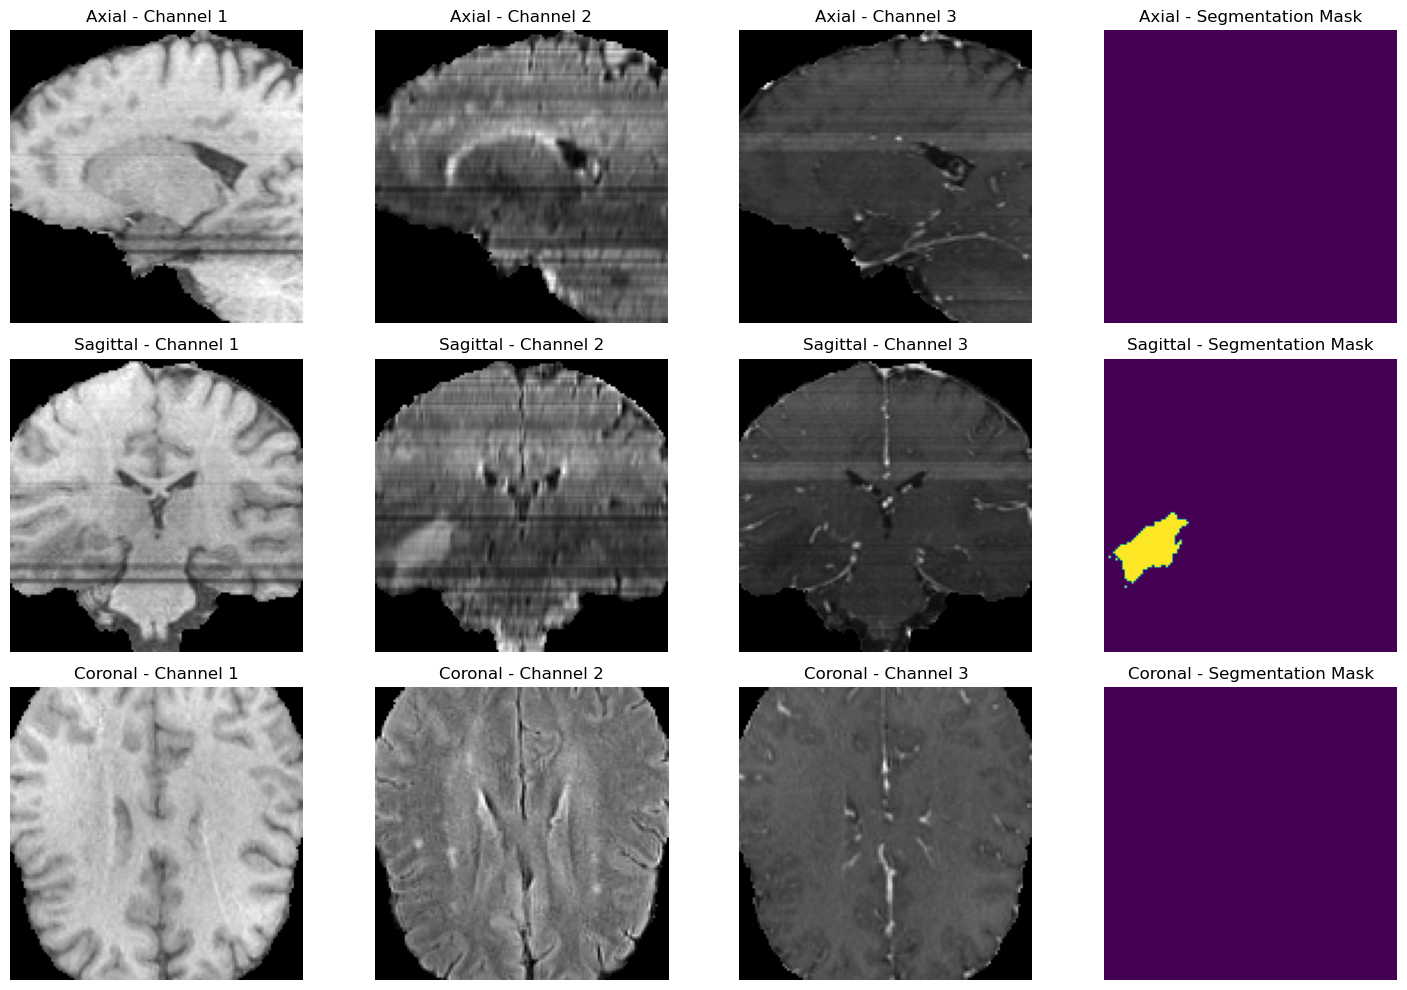

In [17]:
sample = 0  # checking the 2nd sample of the first batch
yhat = y[sample]
yhat = np.argmax(yhat, axis=-1)

layer = 80

fig, axes = plt.subplots(3, 4, figsize=(15, 10))

# Axial View
axes[0, 0].imshow(np.rot90(X[sample, layer, :, :, 0]), cmap='gray')
axes[0, 0].set_title('Axial - Channel 1')
axes[0, 0].axis('off')

axes[0, 1].imshow(np.rot90(X[sample, layer, :, :, 1]), cmap='gray')
axes[0, 1].set_title('Axial - Channel 2')
axes[0, 1].axis('off')

axes[0, 2].imshow(np.rot90(X[sample, layer, :, :, 2]), cmap='gray')
axes[0, 2].set_title('Axial - Channel 3')
axes[0, 2].axis('off')

axes[0, 3].imshow(np.rot90(yhat[layer, :, :]))
axes[0, 3].set_title('Axial - Segmentation Mask')
axes[0, 3].axis('off')

# Sagittal View
axes[1, 0].imshow(np.rot90(X[sample, :, layer, :, 0]), cmap='gray')
axes[1, 0].set_title('Sagittal - Channel 1')
axes[1, 0].axis('off')

axes[1, 1].imshow(np.rot90(X[sample, :, layer, :, 1]), cmap='gray')
axes[1, 1].set_title('Sagittal - Channel 2')
axes[1, 1].axis('off')

axes[1, 2].imshow(np.rot90(X[sample, :, layer, :, 2]), cmap='gray')
axes[1, 2].set_title('Sagittal - Channel 3')
axes[1, 2].axis('off')

axes[1, 3].imshow(np.rot90(yhat[:, layer, :]))
axes[1, 3].set_title('Sagittal - Segmentation Mask')
axes[1, 3].axis('off')

# Coronal View
axes[2, 0].imshow(np.rot90(X[sample, :, :, layer, 0]), cmap='gray')
axes[2, 0].set_title('Coronal - Channel 1')
axes[2, 0].axis('off')

axes[2, 1].imshow(np.rot90(X[sample, :, :, layer, 1]), cmap='gray')
axes[2, 1].set_title('Coronal - Channel 2')
axes[2, 1].axis('off')

axes[2, 2].imshow(np.rot90(X[sample, :, :, layer, 2]), cmap='gray')
axes[2, 2].set_title('Coronal - Channel 3')
axes[2, 2].axis('off')

axes[2, 3].imshow(np.rot90(yhat[:, :, layer]))
axes[2, 3].set_title('Coronal - Segmentation Mask')
axes[2, 3].axis('off')

plt.tight_layout()
plt.show()


In [18]:
#original image
img_path=Train[0]
path=os.path.join(TRAIN_DATASET_PATH,img_path)
p=os.listdir(path)
t1 = [i for i, s in enumerate(p) if 't1.nii' in s]
t2 = [i for i, s in enumerate(p) if 't2.nii' in s]
t1ce = [i for i, s in enumerate(p) if 't1ce.nii' in s]
seg = [i for i, s in enumerate(p) if 'seg.nii' in s]
flair = [i for i, s in enumerate(p) if 'flair.nii' in s]
test_image_flair=nib.load(os.path.join(path,p[flair[0]])).get_fdata()
test_image_t1=nib.load(os.path.join(path,p[t1[0]])).get_fdata()
test_image_t1ce=nib.load(os.path.join(path,p[t1ce[0]])).get_fdata()
#test_image_t2=nib.load(os.path.join(path,p[t2[0]])).get_fdata()
test_seg=nib.load(os.path.join(path,p[seg[0]])).get_fdata()

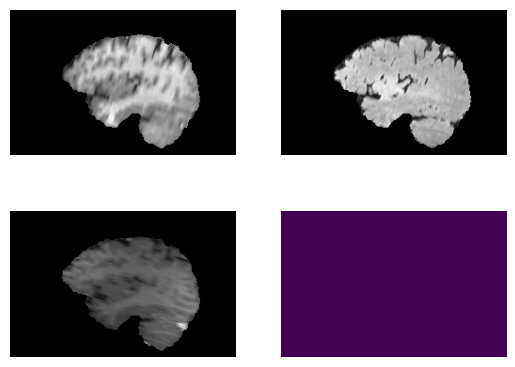

In [19]:
layer=80
plt.subplot(2,2,1)
plt.imshow(np.rot90(test_image_t1[layer,:,:]),cmap='gray')
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(np.rot90(test_image_flair[layer,:,:]),cmap='gray')
plt.axis('off')
plt.subplot(2,2,3)
plt.imshow(np.rot90(test_image_t1ce[layer,:,:]),cmap='gray')
plt.axis('off')
plt.subplot(2,2,4)
plt.imshow(np.rot90(test_seg[layer,:,:]))
plt.axis('off')
plt.show()

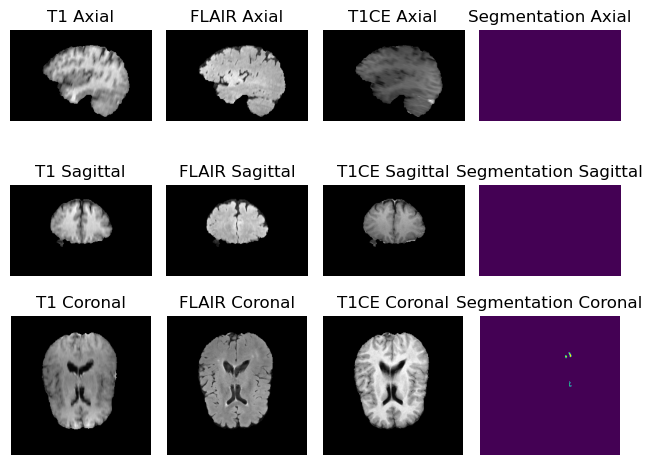

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming test_image_t1, test_image_flair, test_image_t1ce, and test_seg are your image arrays

layer = 80

# Axial View
plt.subplot(3, 4, 1)
plt.imshow(np.rot90(test_image_t1[layer, :, :]), cmap='gray')
plt.title('T1 Axial')
plt.axis('off')

plt.subplot(3, 4, 2)
plt.imshow(np.rot90(test_image_flair[layer, :, :]), cmap='gray')
plt.title('FLAIR Axial')
plt.axis('off')

plt.subplot(3, 4, 3)
plt.imshow(np.rot90(test_image_t1ce[layer, :, :]), cmap='gray')
plt.title('T1CE Axial')
plt.axis('off')

plt.subplot(3, 4, 4)
plt.imshow(np.rot90(test_seg[layer, :, :]))
plt.title('Segmentation Axial')
plt.axis('off')

# Sagittal View
plt.subplot(3, 4, 5)
plt.imshow(np.rot90(test_image_t1[:, layer, :]), cmap='gray')
plt.title('T1 Sagittal')
plt.axis('off')

plt.subplot(3, 4, 6)
plt.imshow(np.rot90(test_image_flair[:, layer, :]), cmap='gray')
plt.title('FLAIR Sagittal')
plt.axis('off')

plt.subplot(3, 4, 7)
plt.imshow(np.rot90(test_image_t1ce[:, layer, :]), cmap='gray')
plt.title('T1CE Sagittal')
plt.axis('off')

plt.subplot(3, 4, 8)
plt.imshow(np.rot90(test_seg[:, layer, :]))
plt.title('Segmentation Sagittal')
plt.axis('off')

# Coronal View
plt.subplot(3, 4, 9)
plt.imshow(np.rot90(test_image_t1ce[:, :, layer]), cmap='gray')
plt.title('T1 Coronal')
plt.axis('off')

plt.subplot(3, 4, 10)
plt.imshow(np.rot90(test_image_flair[:, :, layer]), cmap='gray')
plt.title('FLAIR Coronal')
plt.axis('off')

plt.subplot(3, 4, 11)
plt.imshow(np.rot90(test_image_t1[:, :, layer]), cmap='gray')
plt.title('T1CE Coronal')
plt.axis('off')

plt.subplot(3, 4, 12)
plt.imshow(np.rot90(test_seg[:, :, layer]))
plt.title('Segmentation Coronal')
plt.axis('off')

# Adjust layout to prevent clipping
plt.tight_layout()

# Display the plot
plt.show()


In [21]:
wt=np.array([0.25,0.25,0.25,0.25])
diceloss=sm.losses.DiceLoss(class_weights=wt)
focalloss=sm.losses.CategoricalFocalLoss()
totalloss=diceloss+(1*focalloss)
metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5), sm.metrics.Precision(threshold=0.5), sm.metrics.Recall(threshold=0.5)]

In [22]:
batch_size=1
lr=0.0001
optim=keras.optimizers.Adam(lr)
steps_per_epoch=len(Train)//batch_size
val_steps_per_epoch=len(Validation)//batch_size

In [23]:
# model=sm.Unet(backbone_name='efficientnetb0', input_shape=(128,128,128,3), classes=4, activation='softmax',encoder_weights='imagenet')
# model.compile(optimizer=optim,loss=totalloss,metrics=metrics)
# model.summary()

In [24]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model

def conv_block(x, filters, kernel_size=(3, 3, 3), activation='relu', padding='same'):
    x = layers.Conv3D(filters, kernel_size, activation=activation, padding=padding)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv3D(filters, kernel_size, activation=activation, padding=padding)(x)
    x = layers.BatchNormalization()(x)
    return x

def unet_3d(input_shape=(128, 128, 128, 3), num_classes=4):
    inputs = layers.Input(input_shape)

    # Encoder
    conv1 = conv_block(inputs, 32)
    pool1 = layers.MaxPooling3D(pool_size=(2, 2, 2))(conv1)

    conv2 = conv_block(pool1, 64)
    pool2 = layers.MaxPooling3D(pool_size=(2, 2, 2))(conv2)

    conv3 = conv_block(pool2, 128)
    pool3 = layers.MaxPooling3D(pool_size=(2, 2, 2))(conv3)

    # Middle
    conv4 = conv_block(pool3, 256)

    # Decoder
    up5 = layers.UpSampling3D(size=(2, 2, 2))(conv4)
    concat5 = layers.concatenate([conv3, up5], axis=-1)
    conv5 = conv_block(concat5, 128)

    up6 = layers.UpSampling3D(size=(2, 2, 2))(conv5)
    concat6 = layers.concatenate([conv2, up6], axis=-1)
    conv6 = conv_block(concat6, 64)

    up7 = layers.UpSampling3D(size=(2, 2, 2))(conv6)
    concat7 = layers.concatenate([conv1, up7], axis=-1)
    conv7 = conv_block(concat7, 32)

    outputs = layers.Conv3D(num_classes, (1, 1, 1), activation='softmax')(conv7)

    model = Model(inputs, outputs, name='3D_UNet')
    return model

# Instantiate the model
model = unet_3d(input_shape=(128, 128, 128, 3), num_classes=4)

# Compile the model
model.compile(optimizer=optim, loss=totalloss, metrics=metrics)

# Display model summary
model.summary()


Model: "3D_UNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 128, 3)]   0         []                            
                                                                                                  
 conv3d (Conv3D)             (None, 128, 128, 128, 32)    2624      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 128, 32)    128       ['conv3d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv3d_1 (Conv3D)           (None, 128, 128, 128, 32)    27680     ['batch_normalization[0]

In [25]:
# from tensorflow.keras import layers
# from tensorflow.keras.models import Model

# def conv_block(x, filters, kernel_size=(3, 3, 3), activation='leakyrelu', padding='same'):
#     if activation == 'leakyrelu':
#         activation = layers.LeakyReLU(alpha=0.1)
#     x = layers.Conv3D(filters, kernel_size, activation=activation, padding=padding)(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Conv3D(filters, kernel_size, activation=activation, padding=padding)(x)
#     x = layers.BatchNormalization()(x)
#     return x

# def unet_3d(input_shape=(128, 128, 128, 3), num_classes=4):
#     inputs = layers.Input(input_shape)

#     # Encoder
#     conv1 = conv_block(inputs, 32)
#     pool1 = layers.MaxPooling3D(pool_size=(2, 2, 2))(conv1)

#     conv2 = conv_block(pool1, 64)
#     pool2 = layers.MaxPooling3D(pool_size=(2, 2, 2))(conv2)

#     conv3 = conv_block(pool2, 128)
#     pool3 = layers.MaxPooling3D(pool_size=(2, 2, 2))(conv3)

#     conv4 = conv_block(pool3, 256)
#     pool4 = layers.MaxPooling3D(pool_size=(2, 2, 2))(conv4)

#     conv5 = conv_block(pool4, 512)
#     pool5 = layers.MaxPooling3D(pool_size=(2, 2, 2))(conv5)

#     conv6 = conv_block(pool5, 1024)

#     # Decoder
#     up7 = layers.UpSampling3D(size=(2, 2, 2))(conv6)
#     concat7 = layers.concatenate([conv5, up7], axis=-1)
#     conv7 = conv_block(concat7, 512)

#     up8 = layers.UpSampling3D(size=(2, 2, 2))(conv7)
#     concat8 = layers.concatenate([conv4, up8], axis=-1)
#     conv8 = conv_block(concat8, 256)

#     up9 = layers.UpSampling3D(size=(2, 2, 2))(conv8)
#     concat9 = layers.concatenate([conv3, up9], axis=-1)
#     conv9 = conv_block(concat9, 128)

#     up10 = layers.UpSampling3D(size=(2, 2, 2))(conv9)
#     concat10 = layers.concatenate([conv2, up10], axis=-1)
#     conv10 = conv_block(concat10, 64)

#     up11 = layers.UpSampling3D(size=(2, 2, 2))(conv10)
#     concat11 = layers.concatenate([conv1, up11], axis=-1)
#     conv11 = conv_block(concat11, 32)

#     # Additional Convolutional Blocks
#     conv12 = conv_block(conv11, 16)
#     conv13 = conv_block(conv12, 8)

#     outputs = layers.Conv3D(num_classes, (1, 1, 1), activation='softmax')(conv13)

#     model = Model(inputs, outputs, name='3D_UNet')
#     return model

# # Instantiate the model
# model = unet_3d(input_shape=(128, 128, 128, 3), num_classes=4)

# # Compile the model
# model.compile(optimizer=optim, loss=totalloss, metrics=metrics)

# # Display model summary
# model.summary()


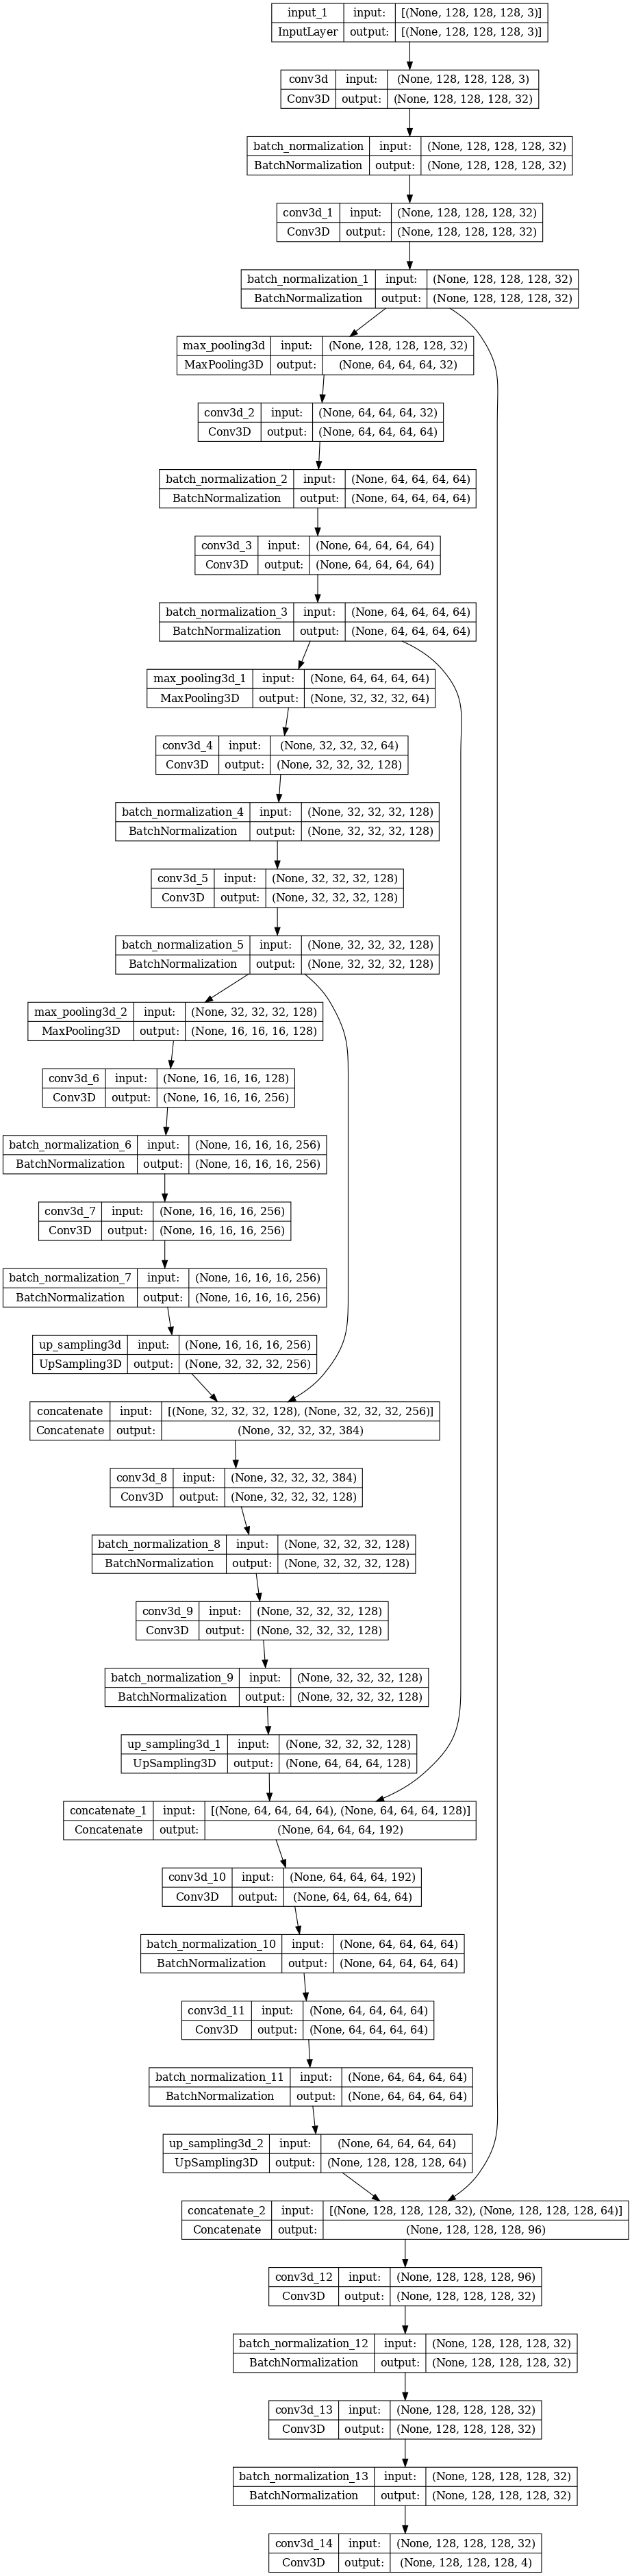

In [26]:
plot_model(model, show_shapes = True,expand_nested = True,dpi = 80)

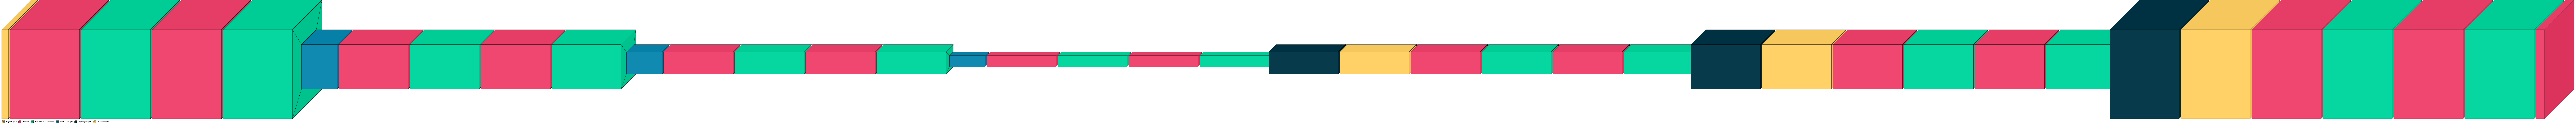

In [27]:
visualkeras.layered_view(model, legend=True)

In [28]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_loss', mode = 'min', patience=5, restore_best_weights=True)

In [29]:
history=model.fit(Train_datagen,epochs=50,validation_data=Val_datagen,verbose=1,steps_per_epoch=steps_per_epoch,validation_steps=val_steps_per_epoch, callbacks = [early_stop])
# model.save('my_mdl.keras')

Epoch 1/50
235/235 [==============================] - 542s 2s/step - loss: 0.9777 - accuracy: 0.8882 - iou_score: 0.2483 - f1-score: 0.3495 - precision: 0.5208 - recall: 0.4003 - val_loss: 0.9612 - val_accuracy: 0.9629 - val_iou_score: 0.2437 - val_f1-score: 0.2742 - val_precision: 0.9405 - val_recall: 0.2496
Epoch 2/50
235/235 [==============================] - 323s 1s/step - loss: 0.9546 - accuracy: 0.9568 - iou_score: 0.4371 - f1-score: 0.5486 - precision: 0.6154 - recall: 0.6208 - val_loss: 1.0101 - val_accuracy: 0.8803 - val_iou_score: 0.3483 - val_f1-score: 0.4259 - val_precision: 0.5481 - val_recall: 0.5556
Epoch 3/50
235/235 [==============================] - 316s 1s/step - loss: 0.9364 - accuracy: 0.9663 - iou_score: 0.5187 - f1-score: 0.6220 - precision: 0.6412 - recall: 0.7130 - val_loss: 0.9589 - val_accuracy: 0.9352 - val_iou_score: 0.4155 - val_f1-score: 0.5025 - val_precision: 0.6116 - val_recall: 0.6388
Epoch 4/50
235/235 [==============================] - 318s 1s/step 

**Higher Round trainings**

In [30]:
# UNet_3D=load_model('/kaggle/input/unet3d-round2/UNet_3D_best_model_round2_128.keras',custom_objects={'dice_loss_plus_1focal_loss':totalloss,'iou_score':sm.metrics.IOUScore(threshold=0.5)})

In [31]:
# UNet_3D.summary()

In [32]:
# plot_model(UNet_3D, show_shapes = True,expand_nested = True,dpi = 80)

In [33]:
# visualkeras.layered_view(UNet_3D, legend=True)

Note the actual model is trained on more than 100 epochs

In [34]:
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
# mc = ModelCheckpoint('UNet_3D_best_model_round3_128.keras', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [35]:
# #30epochs
# history=UNet_3D.fit(Train_datagen,epochs=40,validation_data=Val_datagen,verbose=1,steps_per_epoch=steps_per_epoch,validation_steps=val_steps_per_epoch,callbacks=[es,mc])
# #my_model.save('UNet_3D_128_128_128_round_1.keras')

In [36]:
# model.load_model('/kaggle/input/brats-weight',custom_objects={'dice_loss_plus_1focal_loss':totalloss,'iou_score':sm.metrics.IOUScore(threshold=0.5)})
# model.load_weights('/kaggle/input/brats-weight/saved_model.h5')

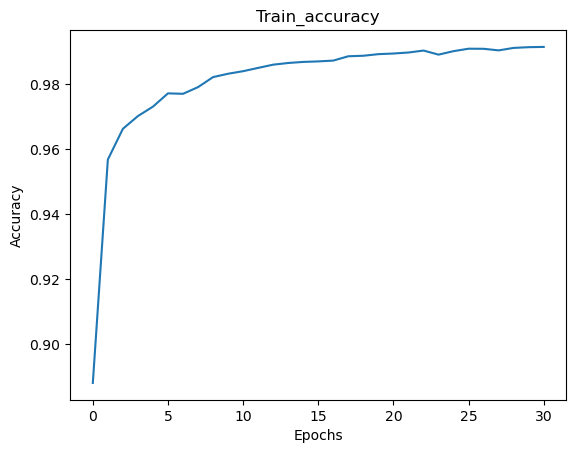

In [37]:
plt.title('Train_accuracy')
plt.plot(history.history['accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

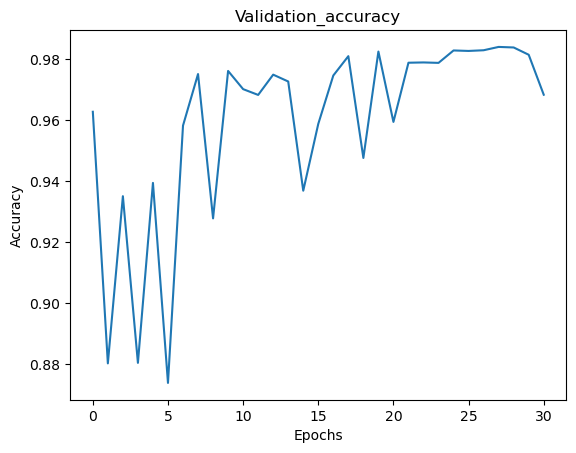

In [38]:
plt.title('Validation_accuracy')
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

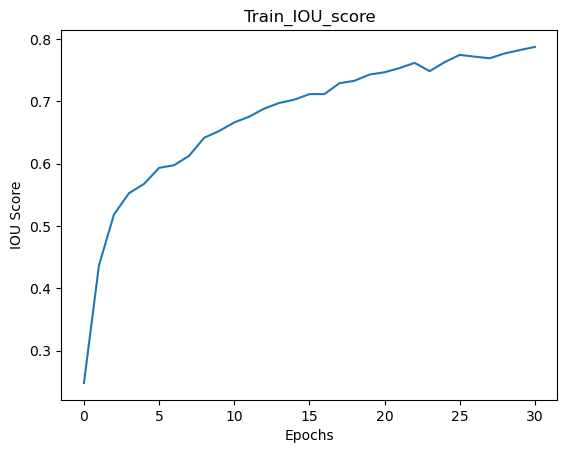

In [39]:
plt.title('Train_IOU_score')
plt.plot(history.history['iou_score'])
plt.xlabel('Epochs')
plt.ylabel('IOU Score')
plt.show()

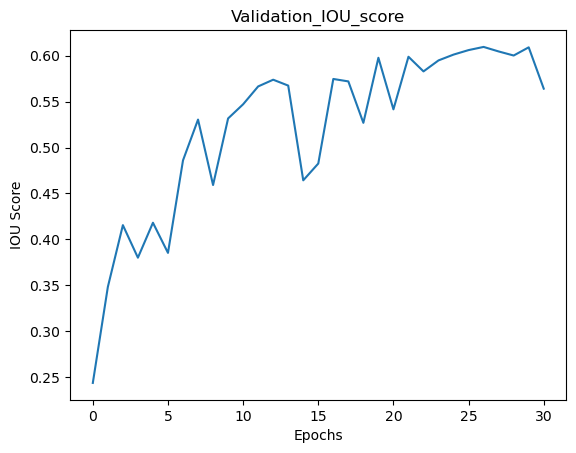

In [40]:
plt.title('Validation_IOU_score')
plt.plot(history.history['val_iou_score'])
plt.xlabel('Epochs')
plt.ylabel('IOU Score')
plt.show()

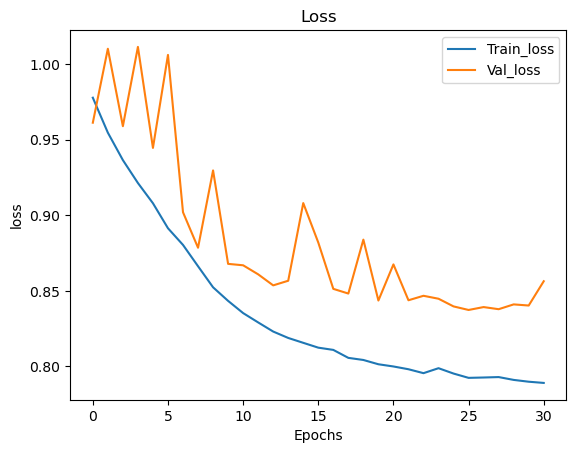

In [41]:
plt.title('Loss')
plt.plot(history.history['loss'],label='Train_loss')
plt.plot(history.history['val_loss'],label='Val_loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.show()

In [42]:
X,y=Test_datagen.__getitem__(10)#fetching the first batch

In [43]:
y_true = y
y_pred=model.predict(X)

1/1 [==============================] - 1s 715ms/step


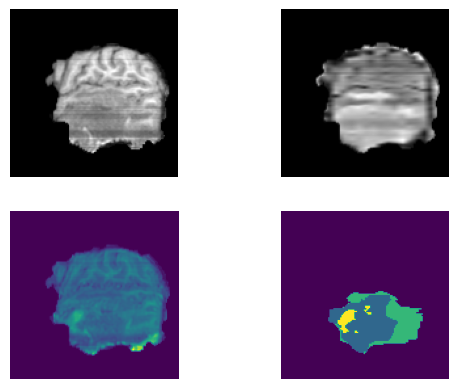

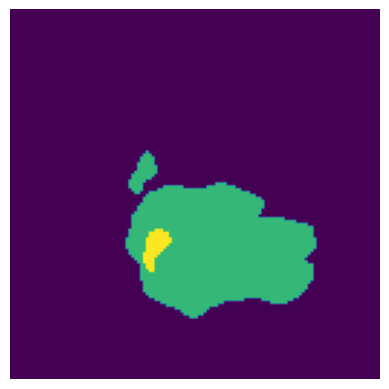

In [44]:
sample=0#checking the 2nd sample of first batch
yhat=y[sample]
yhat=np.argmax(yhat,axis=-1)
layer=120
plt.subplot(2,2,1)
plt.imshow(np.rot90(X[sample,layer,:,:,0]),cmap='gray')
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(np.rot90(X[sample,layer,:,:,1]),cmap='gray')
plt.axis('off')
plt.subplot(2,2,3)
plt.imshow(np.rot90(X[sample,layer,:,:,2]))
plt.axis('off')
plt.subplot(2,2,4)
plt.imshow(np.rot90(yhat[layer,:,:]))
plt.axis('off')
plt.show()

yhat=np.argmax(y_pred[0],axis=-1)
plt.imshow(np.rot90(yhat[layer,:,:]))
plt.axis('off')
plt.show()

In [45]:
# Assuming Test_datagen is your test data generator
# and model is your segmentation model

# Initialize empty lists to store true and predicted segmentation masks
y_true_list = []
y_pred_list = []

# Loop through the test data generator to predict on the full test set
for i in range(len(Test_datagen)):
    X, y = Test_datagen.__getitem__(i)
    y_true_list.append(y)
    y_pred = model.predict(X)
    y_pred_list.append(y_pred)

# Concatenate the list of true and predicted masks into numpy arrays
y_true = np.concatenate(y_true_list, axis=0)
y_pred = np.concatenate(y_pred_list, axis=0)

# Now you have the full true and predicted segmentation masks


1/1 [==============================] - 0s 34ms/step


In [46]:
print(y_true.shape)
print(y_pred.shape)

(74, 128, 128, 128, 4)
(74, 128, 128, 128, 4)


In [47]:
# s_y_true = y_true[:20]
# s_y_pred = y_pred[:20]

In [48]:
# print(s_y_true.shape)
# print(s_y_pred.shape)

In [49]:
import numpy as np

def dice_coefficient(y_true, y_pred):
    dice_scores = {}
    for t in range(y_true.shape[-1]):
        intersection = np.sum(y_true[..., t] * y_pred[..., t], axis=(1,2,3))
        union = np.sum(y_true[..., t], axis=(1,2,3)) + np.sum(y_pred[..., t], axis=(1,2,3))
        dice_scores[f"type {t+1}"] = np.mean((2. * intersection + 1e-6) / (union + 1e-6)) * 100
    return dice_scores

def intersection_over_union(y_true, y_pred):
    iou_scores = {}
    for t in range(y_true.shape[-1]):
        intersection = np.sum(y_true[..., t] * y_pred[..., t], axis=(1,2,3))
        union = np.sum(y_true[..., t], axis=(1,2,3)) + np.sum(y_pred[..., t], axis=(1,2,3)) - intersection
        iou_scores[f"type {t+1}"] = np.mean((intersection + 1e-6) / (union + 1e-6)) * 100
    return iou_scores

def precision(y_true, y_pred):
    precision_scores = {}
    for t in range(y_true.shape[-1]):
        true_positives = np.sum(y_true[..., t] * y_pred[..., t], axis=(1,2,3))
        all_positives = np.sum(y_pred[..., t], axis=(1,2,3))
        precision_scores[f"type {t+1}"] = np.mean((true_positives + 1e-6) / (all_positives + 1e-6)) * 100
    return precision_scores

def recall(y_true, y_pred):
    recall_scores = {}
    for t in range(y_true.shape[-1]):
        true_positives = np.sum(y_true[..., t] * y_pred[..., t], axis=(1,2,3))
        all_true = np.sum(y_true[..., t], axis=(1,2,3))
        recall_scores[f"type {t+1}"] = np.mean((true_positives + 1e-6) / (all_true + 1e-6)) * 100
    return recall_scores

def accuracy(y_true, y_pred):
    accuracy_scores = {}
    for t in range(y_true.shape[-1]):
        correct_predictions = np.sum((y_true[..., t] == 1) & (y_pred[..., t] == 1), axis=(1,2,3))
        total_predictions = np.sum(y_true[..., t] == 1, axis=(1,2,3))
        accuracy_scores[f"type {t+1}"] = np.mean((correct_predictions + 1e-6) / (total_predictions + 1e-6)) * 100
    return accuracy_scores

def f1_score(y_true, y_pred):
    f1_scores = {}
    for t in range(y_true.shape[-1]):
        precisions = precision(y_true, y_pred)
        recalls = recall(y_true, y_pred)
        f1_scores[f"type {t+1}"] = 2 * (precisions[f"type {t+1}"] * recalls[f"type {t+1}"]) / (precisions[f"type {t+1}"] + recalls[f"type {t+1}"] + 1e-6)
    return f1_scores

def compute_metrics(y_true, y_pred):
    dice = dice_coefficient(y_true, y_pred)
    iou = intersection_over_union(y_true, y_pred)
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    acc = accuracy(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return dice, iou, prec, rec, acc, f1

# Example usage:
# Assuming y_true and y_pred are 5D arrays representing ground truth and predicted segmentations respectively
# Shape of y_true and y_pred should be (total_images, depth, height, width, types)

dice_scores, iou_scores, prec_scores, rec_scores, acc_scores, f1_scores = compute_metrics(y_true, y_pred)

print("Dice:")
for key, value in dice_scores.items():
    print(f"{key}: {value:.2f}")

print("\nIoU:")
for key, value in iou_scores.items():
    print(f"{key}: {value:.2f}")

print("\nPrecision:")
for key, value in prec_scores.items():
    print(f"{key}: {value:.2f}")

print("\nRecall:")
for key, value in rec_scores.items():
    print(f"{key}: {value:.2f}")

print("\nAccuracy:")
for key, value in acc_scores.items():
    print(f"{key}: {value:.2f}")

print("\nF1 Score:")
for key, value in f1_scores.items():
    print(f"{key}: {value:.2f}")


Dice:
type 1: 98.97
type 2: 55.20
type 3: 62.26
type 4: 62.17

IoU:
type 1: 98.05
type 2: 44.59
type 3: 49.98
type 4: 51.94

Precision:
type 1: 99.26
type 2: 67.82
type 3: 66.51
type 4: 67.47

Recall:
type 1: 98.78
type 2: 55.89
type 3: 68.55
type 4: 69.83

Accuracy:
type 1: 0.00
type 2: 16.00
type 3: 7.36
type 4: 29.72

F1 Score:
type 1: 99.02
type 2: 61.28
type 3: 67.52
type 4: 68.63


In [50]:
# from IPython.display import FileLink
# import os
# os.chdir(r'/kaggle/working/')
# FileLink(r'/kaggle/working/UNet_3D_best_model_round3_128.keras')

In [51]:
# model.save('saved_model.keras')

In [52]:
model.save_weights('saved_model.h5')